For this code the following reference has been used:

Burke, R. (2022, January 5). How to Implement Deep Neural Networks for Time-to-Event Analyses. Medium. https://towardsdatascience.com/how-to-implement-deep-neural-networks-for-time-to-event-analyses-9aa0aeac4717



In [3]:
import pandas as pd
import numpy as np
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')


Mounted at /content/drive


In [16]:
# Model MET  validation set -> geeft c-index van rond 0.796 (in python)

!pip install torchtuples
!pip install pycox
!pip install eli5

import pandas as pd
import numpy as np
import torchtuples as tt
from sklearn.model_selection import train_test_split
from pycox.models import DeepHitSingle
import torch
from eli5.permutation_importance import get_score_importances

# Load the data
train_data_lasso = pd.read_csv("/content/drive/MyDrive/thesis data/train_data_lasso_new2.csv")
test_data_lasso = pd.read_csv("/content/drive/MyDrive/thesis data/test_data_lasso_new2.csv")


# Add column with time
train_data_lasso["timeinput"] = train_data_lasso["time"]
train_data_lasso["timeinput"] = train_data_lasso["timeinput"].replace(2010,0)
train_data_lasso["timeinput"] = train_data_lasso["timeinput"].replace(2011,1)
train_data_lasso["timeinput"] = train_data_lasso["timeinput"].replace(2013,2)
train_data_lasso["timeinput"] = train_data_lasso["timeinput"].replace(2014,3)
train_data_lasso["timeinput"] = train_data_lasso["timeinput"].replace(2015,4)
train_data_lasso["timeinput"] = train_data_lasso["timeinput"].replace(2017,5)



test_data_lasso["timeinput"] = test_data_lasso["time"]
test_data_lasso["timeinput"] = test_data_lasso["timeinput"].replace(2010,0)
test_data_lasso["timeinput"] = test_data_lasso["timeinput"].replace(2011,1)
test_data_lasso["timeinput"] = test_data_lasso["timeinput"].replace(2013,2)
test_data_lasso["timeinput"] = test_data_lasso["timeinput"].replace(2014,3)
test_data_lasso["timeinput"] = test_data_lasso["timeinput"].replace(2015,4)
test_data_lasso["timeinput"] = test_data_lasso["timeinput"].replace(2017,5)

# Split the data into train and validation 
df_train = train_data_lasso
df_val = df_train.sample(frac=0.2)
df_train = df_train.drop(df_val.index)

y_train = (np.array(df_train["timeinput"]), np.array(df_train["status"].astype("float32")))
y_val = (np.array(df_val["timeinput"]), np.array(df_val["status"].astype("float32")))
y_test = (np.array(test_data_lasso["timeinput"]), np.array(test_data_lasso["status"].astype("float32")))

# Create train and validation data tuples
x_train = df_train.drop(['time', 'status', 'timeinput'], axis=1).values
x_val = df_val.drop(['time', 'status', 'timeinput'], axis=1).values
x_train=np.float32(x_train[:][:])
x_val=np.float32(x_val[:][:])

train = (x_train, y_train)
val = (x_val, y_val)

# Create the DeepHit model
in_features = x_train[0].shape[0]
out_features = 6
num_nodes = [128]
batch_norm = True

net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm)

optimizer = tt.optim.AdamWR()
model = DeepHitSingle(net, optimizer, duration_index=np.array([2010, 2011, 2013, 2014, 2015, 2017]))

# Train the model
model.optimizer.set_lr(0.01)
epochs = 1000
batch_size = 256
callbacks = [tt.cb.EarlyStoppingCycle()]
log = model.fit(x_train, y_train, batch_size, epochs, callbacks, val_data=val, verbose = False)


# Evaluate the model on test data
x_test = test_data_lasso.drop(['time', 'status', 'timeinput'], axis=1).values
x_test=np.float32(x_test[:][:])

surv = model.predict_surv_df(x_test)
surv

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


,0,1,2,3,4,5,6,7,8,9,...,889,890,891,892,893,894,895,896,897,898
2010,0.869233,0.803985,0.847713,0.720557,0.868770,0.761504,0.779033,0.864084,0.818404,0.878366,...,0.808513,0.848556,0.812651,0.813535,0.881385,0.889400,0.775920,0.853302,0.886908,0.874451
2011,0.743272,0.683886,0.723202,0.599357,0.746429,0.639050,0.651509,0.736220,0.690938,0.753955,...,0.684535,0.723645,0.648702,0.686477,0.756900,0.762098,0.625926,0.729324,0.761406,0.708076
2013,0.736027,0.676910,0.716568,0.593923,0.739308,0.632950,0.645476,0.729365,0.684607,0.746606,...,0.677484,0.716452,0.644484,0.679991,0.749607,0.754638,0.621653,0.722014,0.754250,0.702890
2014,0.733536,0.674507,0.714012,0.591693,0.736870,0.630605,0.643263,0.726945,0.682226,0.744043,...,0.675057,0.713947,0.640452,0.677676,0.747164,0.752342,0.617708,0.719542,0.751877,0.698826
2015,0.731526,0.672646,0.711983,0.590150,0.734828,0.628970,0.641586,0.725012,0.680342,0.741918,...,0.673155,0.712013,0.638830,0.675753,0.745018,0.750271,0.616171,0.717537,0.749809,0.697036
2017,0.731451,0.672578,0.711909,0.590087,0.734758,0.628902,0.641519,0.724940,0.680273,0.741843,...,0.673088,0.711943,0.638708,0.675687,0.744946,0.750198,0.616053,0.717466,0.749736,0.696916


In [8]:

surv.to_csv('/content/drive/MyDrive/surv_new_test_0.797.csv', index=False)

In [19]:

from pycox.evaluation.concordance import concordance_td
from pycox.evaluation import EvalSurv
from sklearn.metrics import brier_score_loss

ev = EvalSurv(surv, *y_test) # surv
c_index = ev.concordance_td('antolini')

print("C_INDEX python  :", c_index)


/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic
/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic
/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


C_INDEX python  : 0.0


/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic
/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic
/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic
/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic
/usr/local/lib/python3.10/di

,0
pppadate_yrmo,0.0
how_long_relationship,0.0
ppeduc.13,0.0
ppethm.2,0.0
ppmarit.4,0.0
ppmarit.5,0.0
ppreg9.4,0.0
ppreg9.5,0.0
papglb_friend.4,0.0
pphhcomp11_member2_relationship.2,0.0


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

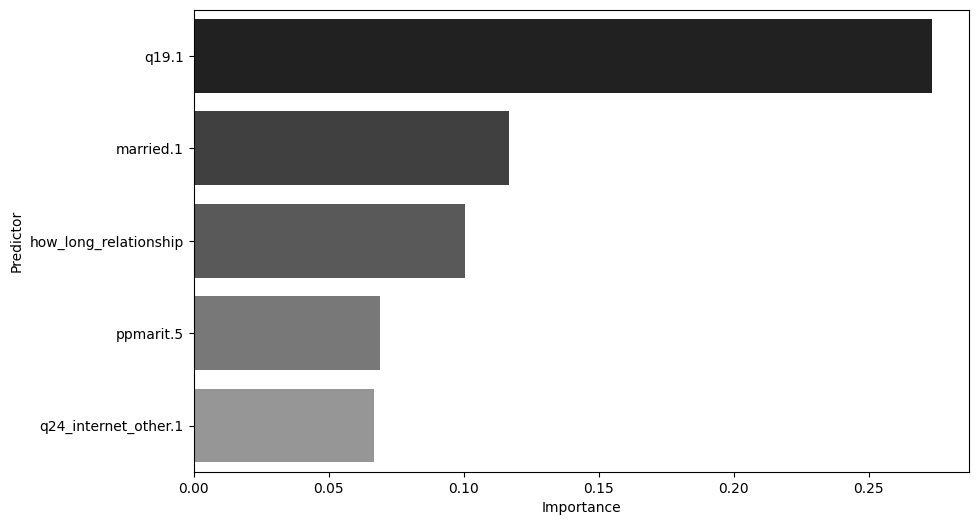

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files


feature_importances_df = pd.read_csv("/content/drive/MyDrive/thesis data/top_5_predictors.csv")

# Define a custom color palette with shades of grey

colors = ['#212121', '#404040', '#595959', '#787878', '#969696']

# Create a bar plot using seaborn with the custom color palette
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importances_df['Importance'], y=feature_importances_df['Predictor'], palette=colors)
plt.xlabel('Importance')
plt.ylabel('Predictor')

# Save the figure to Google Drive
plt.savefig("feature importance.png")
files.download("feature importance.png")

plt.show()
